In [1]:
### Merge ADCP 5-min files: directly from Mule
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import math
import cftime
import sys
path_nhchi = os.path.expanduser('~/Documents/projects/analytical-tools/py_nhchi/')
# adding to the system path
sys.path.insert(0, path_nhchi)
# from read_topo import load_topo_arctic_HiRes, load_topo_arctic
from convert_time import datetime_to_yearday

In [2]:
year = '2023'
platf_num = '1042'
### folder name that hosts the adcp data
# for importing saildrone data from mule: make sure it is mounted (mule.pmel.noaa.gov)
if year == '2021':
    sd_year = ['1031','1040','1045','1048','1060']
    path = '/Volumes/disk3/projects/sdig-external/sdig/saildrone/hurricane_monitoring_2021/adcp/'+platf_num+'/'
elif year == '2022':
    sd_year = ['1031','1032','1040','1059','1078','1083','1084']
    path = '/Volumes/disk3/projects/sdig-external/sdig/saildrone/high_resolution/hurricane_monitoring_2022/2022_atlantic_hurricane_mission/sd-'+platf_num+'/adcp/5min/'
elif year == '2023':
    sd_year = ['1031','1036','1040','1041','1042','1045','1057','1064','1065','1068','1069','1083']
    path = '/Volumes/disk3/projects/sdig-external/sdig/saildrone/hurricane_monitoring_2023/adcp/'+platf_num+'/'
elif year == '2024':
    sd_year = ['1030','1031','1036','1040','1041','1042','1045','1057','1068','1069','1083','1091']
    path = '/Volumes/disk3/projects/sdig-external/sdig/saildrone/noaa_hurricane_2024/adcp/'+platf_num+'/'
### test
# filenames = np.sort( os.listdir('/Volumes/disk3/projects/sdig-external/sdig/saildrone/hurricane_monitoring_2021/hurricane_sam/') )
# filenames = np.sort( os.listdir('/Volumes/disk3/projects/sdig-external/sdig/saildrone/high_resolution/hurricane_monitoring_2022/2022_atlantic_hurricane_mission/sd-'+platf_num+'/adcp/5min/') )
# print(filenames)

In [3]:
filenames_all = np.sort( os.listdir(path) )
print('Number of Files in for this directory on Mule:',len(filenames_all))
pathout = os.getcwd()+'/fig_merge_raw_adcp/'
if os.path.isdir(pathout):
    pass
else:
    os.mkdir(pathout)
### retain the filenames wanted only
filenames = np.array([])
for file in filenames_all:
    if ('saildrone' in file) & ('.nc' in file):
        filenames = np.append(filenames, file)
print('Files have "saildrone" & ".nc" in the sub-directory on Mule:',len(filenames))
# print(filenames)
### the list of variables I do not want for now
vars_no = ['trajectory','nav_start_time','nav_end_time','nav_start_latitude','nav_end_latitude',\
           'nav_start_longitude','nav_end_longitude','beam']
### the list of variables that do not have time dimension (depth only)
vars_nostack = ['cell_depth']

Number of Files in for this directory on Mule: 111
Files have "saildrone" & ".nc" in the sub-directory on Mule: 111


In [4]:
### try open the nc files and see how many can be opened
print('check numbers of files can be open or not.')
numOK = 0
numBAD = 0
filenames_canopen = []
for f in range( len(filenames) ):
    try: # block raising an exception
        ds = nc.Dataset(path+'/'+filenames[f])
        test = ds.variables['cell_depth'][:]
        ds.close()
        numOK = numOK + 1
        filenames_canopen.append(filenames[f])
        # print('Done',filenames[f])
    except: # doing nothing on exception
        numBAD = numBAD + 1
        # print('cannot open file:',filenames[f])
        pass
print(numOK,'can be open.')
print(numBAD,'cannot be open.')

check numbers of files can be open or not.
111 can be open.
0 cannot be open.


In [5]:
### create a dictionary
vars_dic = {}
vars_dic_attr = {}
attr = ['long_name','units']
ds = nc.Dataset(path+'/'+filenames_canopen[0])
# print(ds)
nz = len( ds.variables['cell_depth'][:] )
varnms = list( ds.variables.keys() )
### add empty items to the dictionary 
for i in range( len(varnms) ):
    vkey = varnms[i]
    if vkey not in vars_no:
        item = ds.variables[vkey][:]
        vars_dic[vkey] = np.empty( item.shape )
        ### record attributes
        for a in range( len(attr) ):
            # ds.variables[vkey].units
            str_eval = "ds.variables['" + vkey + "']." + attr[a]
            vars_dic_attr[vkey+'-'+attr[a]] = eval(str_eval)
        # print(vkey, item.shape, vars_dic[vkey].shape)
print(len(varnms),'variables in nc file &', len(vars_dic),'variables are selected to append')
### go through each (mostly daily) nc file & append the selected variables 
for f in range( 3):#len(filenames_canopen) ):
    try: # block raising an exception
        ds = nc.Dataset(path+'/'+filenames_canopen[f])
        for i in range( len(varnms) ):
            vkey = varnms[i]
            if (vkey not in vars_no) & (vkey not in vars_nostack):
                # print(vkey)
                vkey = varnms[i]
                item_old = vars_dic[vkey]
                item_app = np.squeeze( ds.variables[vkey][:] ) # add np.squeeze for 2021
                ### append in time dimension only
                if f == 0:
                    vars_dic[vkey] = item_app
                else:
                    vars_dic[vkey] = np.concatenate( (item_old, item_app),axis=0 )
                if (f == 0):# | (f == len(filenames)-1):
                    vars_dic[vars_nostack[0]] = ds.variables[vars_nostack[0]][:]
                    # print(ds.variables[vkey]._FillValue)
                    # print(vkey,item_old.shape, item_app.shape, vars_dic[vkey].shape)
        ds.close()
        print('Done',filenames_canopen[f])
    except: # doing nothing on exception
        pass
    # cur_spd = np.sqrt( np.square(u)+np.square(v) )*100  # cm/s
print(vars_dic['time'].shape)

33 variables in nc file & 26 variables are selected to append
Done saildrone-gen_6-hurricane_monitoring_2023-sd1083-20230707T000000-20230707T235959-5_minutes-v1.1688776263350.nc
Done saildrone-gen_6-hurricane_monitoring_2023-sd1083-20230708T000000-20230708T235959-5_minutes-v1.1691101939804.nc
Done saildrone-gen_6-hurricane_monitoring_2023-sd1083-20230709T000000-20230709T235959-5_minutes-v1.1691101940775.nc
(864,)


(864,) (864,)
is time_out monotonic? --> True
(864,) (864,)
<class 'tuple'> 2 [16156800. 16157100. 16157400. 16157700. 16158000. 16158300. 16158600.
 16158900. 16159200. 16159500. 16159800. 16160100. 16160400. 16160700.
 16161000. 16161300. 16161600. 16161900. 16162200. 16162500. 16162800.
 16163100. 16163400. 16163700. 16164000. 16164300. 16164600. 16164900.
 16165200. 16165500. 16165800. 16166100. 16166400. 16166700. 16167000.
 16167300. 16167600. 16167900. 16168200. 16168500. 16168800. 16169100.
 16169400. 16169700. 16170000. 16170300. 16170600. 16170900. 16171200.
 16171500. 16171800. 16172100. 16172400. 16172700. 16173000. 16173300.
 16173600. 16173900. 16174200. 16174500. 16174800. 16175100. 16175400.
 16175700. 16176000. 16176300. 16176600. 16176900. 16177200. 16177500.
 16177800. 16178100. 16178400. 16178700. 16179000. 16179300. 16179600.
 16179900. 16180200. 16180500. 16180800. 16181100. 16181400. 16181700.
 16182000. 16182300. 16182600. 16182900. 16183200. 16183500. 16183800.

<Figure size 432x288 with 0 Axes>

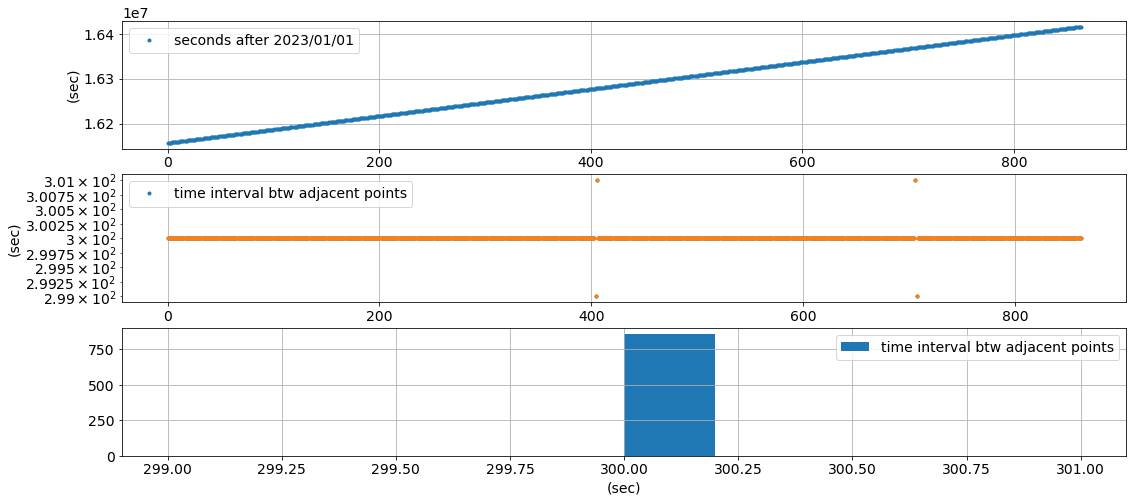

In [6]:
### compute the time as seconds since year-01-01
dtime = np.array([datetime.datetime(1970,1,1)+datetime.timedelta(seconds= vars_dic['time'][i]) for i in range(len(vars_dic['time']))])
time_out = np.array([(dtime[i]-datetime.datetime(int(year),1,1)).total_seconds() for i in range(len(dtime))])
print(dtime.shape, time_out.shape)
### check if time is monotonic and unique
def isMonotonic(A):
    return (all(A[i] <= A[i + 1] for i in range(len(A) - 1)) or
            all(A[i] >= A[i + 1] for i in range(len(A) - 1)))
print('is time_out monotonic? -->', isMonotonic(time_out))

nrow = 3
plt.clf()
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(nrow,1, figsize=(18, 8))
plt.subplot(nrow,1,1)
plt.plot(time_out,'.',label='seconds after '+year+'/01/01')
plt.ylabel('(sec)'); plt.legend()
plt.subplot(nrow,1,2)
plt.semilogy(np.diff(np.sort(time_out)),'.',label='time interval btw adjacent points')
plt.semilogy(np.diff(time_out),'.')
plt.ylabel('(sec)'); plt.legend()
plt.subplot(nrow,1,3)
plt.hist(np.diff(np.sort(time_out)),label='time interval btw adjacent points')
plt.xlabel('(sec)'); plt.legend()
### figure settings
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    plt.grid()
print(np.unique(time_out).shape, time_out.shape)
test = np.unique(time_out, return_index=False, return_inverse=False, return_counts=True)
print(type(test), len(test), test[0])

dict_keys(['time', 'latitude', 'longitude', 'cell_depth', 'roll', 'pitch', 'heading', 'vel_east', 'vel_north', 'vel_up', 'error_vel', 'echo_intensity', 'correlation', 'vehicle_vel_north', 'vehicle_vel_east', 'vehicle_vel_up', 'bt_range', 'bt_cor', 'bt_vel_east', 'bt_vel_north', 'bt_vel_up', 'bt_amp', 'bt_percent_good', 'percent_good_4_beam', 'percent_good_3_beam', 'percent_good'])
time (864,)
latitude (864,)
longitude (864,)
roll (864,)
pitch (864,)
heading (864,)
vel_east (864, 50)
vel_north (864, 50)
vel_up (864, 50)
error_vel (864, 50)
echo_intensity (864, 4, 50)
correlation (864, 4, 50)
vehicle_vel_north (864,)
vehicle_vel_east (864,)
vehicle_vel_up (864,)
bt_range (864, 4)
bt_cor (864, 4)
bt_vel_east (864,)
bt_vel_north (864,)
bt_vel_up (864,)
bt_amp (864, 4)
bt_percent_good (864, 4)
percent_good_4_beam (864, 50)
percent_good_3_beam (864, 50)
percent_good (864, 50)


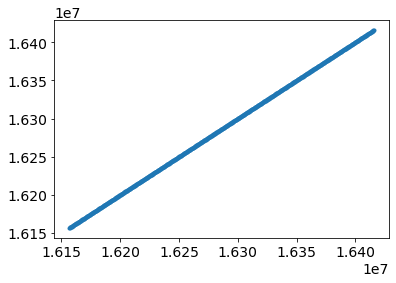

In [7]:
### sort data so that the time is monotonically increasing --> then find unique time
it_sort = np.argsort(time_out)
time_sort = time_out[it_sort]
time_uniq, it_uniq = np.unique(time_sort, return_index=True)
plt.plot(time_uniq, time_sort[it_uniq],'.')

vkey_all = vars_dic.keys()
print(vkey_all)
for vkey in vkey_all:
    if vkey != 'cell_depth':
        if np.ndim(vars_dic[vkey]) == 1:
            data = vars_dic[vkey][it_sort]
            data_uniq = data[it_uniq]            
        elif np.ndim(vars_dic[vkey]) == 2:
            data = vars_dic[vkey][it_sort,:]
            data_uniq = data[it_uniq,:]
        elif np.ndim(vars_dic[vkey]) == 3:
            data = vars_dic[vkey][it_sort,:,:]
            data_uniq = data[it_uniq,:,:]
        ## replace
        vars_dic[vkey] = data_uniq
        print(vkey,vars_dic[vkey].shape)

In [13]:
### write merged adcp data to netcdf file: https://unidata.github.io/python-training/workshop/Bonus/netcdf-writing/
try: ncfile.close()  # just to be safe, make sure dataset is not already open.
except: pass
ncfname_out = 'adcp-raw-merge-'+year+'-SD'+platf_num+'.nc'
# if os.path.exists( ncfname_out ):
#     os.remove('adcp-5min-merge-'+year+'-SD'+platf_num+'.nc')
ncfile = nc.Dataset(ncfname_out,mode='w',format='NETCDF4_CLASSIC') 
print(ncfile)
### creating dimensions
depth_dim = ncfile.createDimension('depth', len(vars_dic['cell_depth'])) # depth axis
time_dim = ncfile.createDimension('time', len(time_uniq)) # unlimited axis (can be appended to).
beam_dim = ncfile.createDimension('beam', 4)
for dim in ncfile.dimensions.items():
    print(dim)
### creating attributes
ncfile.title='Merged files for '+year+' SD-'+platf_num
print(ncfile.title)
ncfile.subtitle="Only selected variables for adcp measurements are here. Temporal resolution is ~10-minute."
print(ncfile.subtitle)
print(ncfile)
### move the writing data to new variables
depth_out = vars_dic['cell_depth']

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: 
('depth', <class 'netCDF4._netCDF4.Dimension'>: name = 'depth', size = 50)
('time', <class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 51083)
('beam', <class 'netCDF4._netCDF4.Dimension'>: name = 'beam', size = 4)
Merged files for 2023 SD-1083
Only selected variables for adcp measurements are here. Temporal resolution is ~10-minute.
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: Merged files for 2023 SD-1083
    subtitle: Only selected variables for adcp measurements are here. Temporal resolution is ~10-minute.
    dimensions(sizes): depth(50), time(51083), beam(4)
    variables(dimensions): 
    groups: 


In [14]:
### Creating variables
depth = ncfile.createVariable('depth', np.float64, ('depth',))
depth.units = 'meter'
depth.long_name = 'depth'
time = ncfile.createVariable('time', np.float64, ('time',))
time.units = 'seconds since '+year+'-01-01'
time.long_name = 'time'
### 1D variables
vars_names = ['longitude','latitude','pitch','roll','heading','vehicle_vel_east','vehicle_vel_north','vehicle_vel_up','bt_vel_east','bt_vel_north','bt_vel_up',\
           'vel_east','vel_north','vel_up','error_vel','percent_good_4_beam','percent_good_3_beam','percent_good',\
            'bt_range','bt_cor','bt_amp','bt_percent_good',\
                'echo_intensity','correlation']
### 1: (time,) 2: (time, cell_depth) 3: (time, beam) 4: (time, beam, cell_depth)
dim_cat = [1,1,1,1,1,1,1,1,1,1,1,\
      2,2,2,2,2,2,2,\
        3,3,3,3,\
            4,4]
for i in range( len(vars_names) ):
    ### create variables with respective dimensions categorized by dim_cat
    if dim_cat[i] == 1:
        str_exec = vars_names[i] + "= ncfile.createVariable('" + vars_names[i] + "', np.float64, ('" + 'time' + "',))"
        exec(str_exec)
        print(i,str_exec)
    elif dim_cat[i] == 2:
        str_exec = vars_names[i] + "= ncfile.createVariable('" + vars_names[i] + "', np.float64, ('" + 'time' + "','"+ 'depth' +"'))"
        exec(str_exec)
        print(i,str_exec)
    elif dim_cat[i] == 3:
        str_exec = vars_names[i] + "= ncfile.createVariable('" + vars_names[i] + "', np.float64, ('" + 'time' + "','"+ 'beam' +"'))"
        exec(str_exec)
        print(i,str_exec)
    else: 
        str_exec = vars_names[i] + "= ncfile.createVariable('" + vars_names[i] + \
            "', np.float64, ('" + 'time' + "','"+ 'beam' + "','" + 'depth' +"'))"
        exec(str_exec)
        print(i,str_exec)
     # ### add attributes
    for a in range( len(attr) ):
        str_exec = vars_names[i] + "."+ attr[a] + " = '"+ vars_dic_attr[vars_names[i]+'-'+attr[a]] + "'"
        exec(str_exec)

0 longitude= ncfile.createVariable('longitude', np.float64, ('time',))
1 latitude= ncfile.createVariable('latitude', np.float64, ('time',))
2 pitch= ncfile.createVariable('pitch', np.float64, ('time',))
3 roll= ncfile.createVariable('roll', np.float64, ('time',))
4 heading= ncfile.createVariable('heading', np.float64, ('time',))
5 vehicle_vel_east= ncfile.createVariable('vehicle_vel_east', np.float64, ('time',))
6 vehicle_vel_north= ncfile.createVariable('vehicle_vel_north', np.float64, ('time',))
7 vehicle_vel_up= ncfile.createVariable('vehicle_vel_up', np.float64, ('time',))
8 bt_vel_east= ncfile.createVariable('bt_vel_east', np.float64, ('time',))
9 bt_vel_north= ncfile.createVariable('bt_vel_north', np.float64, ('time',))
10 bt_vel_up= ncfile.createVariable('bt_vel_up', np.float64, ('time',))
11 vel_east= ncfile.createVariable('vel_east', np.float64, ('time','depth'))
12 vel_north= ncfile.createVariable('vel_north', np.float64, ('time','depth'))
13 vel_up= ncfile.createVariable('ve

In [15]:
### writing data
# Note: the ":" is necessary in these "write" statements
depth[:] = depth_out
time[:] = time_uniq
for i in range( len(vars_names) ):
    if dim_cat[i] == 1:
        str_exec = vars_names[i] + "[:]= vars_dic['" + vars_names[i] + "']"
    elif (dim_cat[i] == 2 ) | (dim_cat[i] == 3):
        str_exec = vars_names[i] + "[:,:]= vars_dic['" + vars_names[i] + "']"
    else:
        str_exec = vars_names[i] + "[:,:,:]= vars_dic['" + vars_names[i] + "']"
    exec(str_exec)    
print(ncfile)
# close the Dataset.
ncfile.close(); print('Dataset is closed!')

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: Merged files for 2023 SD-1083
    subtitle: Only selected variables for adcp measurements are here. Temporal resolution is ~10-minute.
    dimensions(sizes): depth(50), time(51083), beam(4)
    variables(dimensions): float64 depth(depth), float64 time(time), float64 longitude(time), float64 latitude(time), float64 pitch(time), float64 roll(time), float64 heading(time), float64 vehicle_vel_east(time), float64 vehicle_vel_north(time), float64 vehicle_vel_up(time), float64 bt_vel_east(time), float64 bt_vel_north(time), float64 bt_vel_up(time), float64 vel_east(time, depth), float64 vel_north(time, depth), float64 vel_up(time, depth), float64 error_vel(time, depth), float64 percent_good_4_beam(time, depth), float64 percent_good_3_beam(time, depth), float64 percent_good(time, depth), float64 bt_range(time, beam), float64 bt_cor(time, beam), float64 bt_amp(time, beam), float64 bt_percent_

min time difference= 299.0 sec
1st & last time in file: 07/07 00:00Z 07/09 23:55Z
0 time gaps that are > 30 min
The corresponding time gaps (in mins) []


Text(0.5, 0.98, 'Time intervals (t(i+1)-t(i)): Hurricane 2023 - 1083')

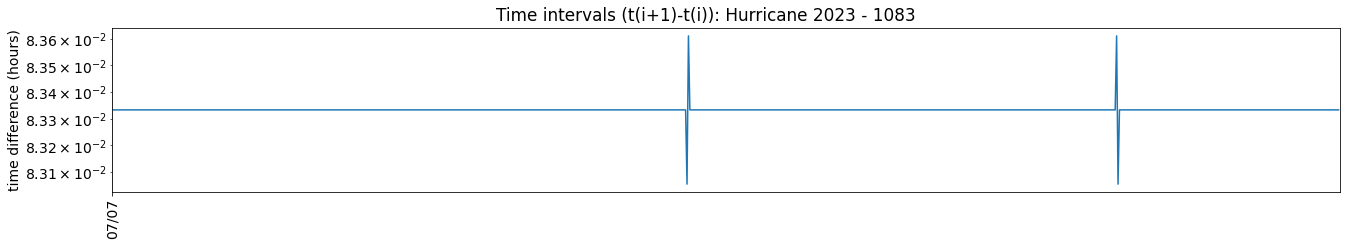

In [8]:
### plot time intervals (time(i+1)-time(i)) and print time gaps
fig, axes = plt.subplots(1)
fig.set_size_inches(22,3)
test = vars_dic['time']
dtime = np.array([datetime.datetime(1970,1,1)+datetime.timedelta(seconds= vars_dic['time'][i]) for i in range(len(vars_dic['time']))])
dtest = np.array([(test[i+1]-test[i])/3600 for i in range( len(test)-1 )]) # 
plt.semilogy(dtime[:-1],dtest)
ddays = (np.max(dtime)-np.min(dtime)).days
xticks = [np.min(dtime)+datetime.timedelta(days=5*i) for i in range(ddays)]
xtickslabel = [xticks[i].strftime('%m/%d') for i in range(ddays)]
plt.xticks(xticks)
plt.gca().set_xticklabels(xtickslabel, rotation=90)
plt.ylabel('time difference (hours)')
plt.xlim([dtime[0],dtime[-1]])
plt.grid()
print('min time difference=',np.min(dtest)*3600,'sec')
print('1st & last time in file:',dtime[0].strftime('%m/%d %H:%MZ'),dtime[-1].strftime('%m/%d %H:%MZ'))
### find data gaps
d5min = (datetime.datetime(int(year),1,1,0,5,0)-datetime.datetime(int(year),1,1)).total_seconds()/3600
d10min = (datetime.datetime(int(year),1,1,0,10,0)-datetime.datetime(int(year),1,1)).total_seconds()/3600
d30min = (datetime.datetime(int(year),1,1,0,30,0)-datetime.datetime(int(year),1,1)).total_seconds()/3600
d60min = (datetime.datetime(int(year),1,1,1,0,0)-datetime.datetime(int(year),1,1)).total_seconds()/3600
# i_tgap = np.where( dtest > d30min )[0]
i_tgap = np.where( dtest > d30min )[0]
print(len(i_tgap),'time gaps that are > 30 min')
print('The corresponding time gaps (in mins)',dtest[i_tgap]*60)
for i in range( len(i_tgap) ):
    print(dtime[i_tgap[i]].strftime('%m/%d %H:%MZ'),'-',dtime[i_tgap[i]+1].strftime('%m/%d %H:%MZ'))

plt.suptitle('Time intervals (t(i+1)-t(i)): Hurricane '+year+' - '+platf_num)
### save figure
fig.savefig(pathout+'time_intervals_'+year+'-'+platf_num+'-adcp.png', dpi=300,bbox_inches='tight')

['time', 'latitude', 'longitude', 'cell_depth', 'roll', 'pitch', 'heading', 'vel_east', 'vel_north', 'vel_up', 'error_vel', 'echo_intensity', 'correlation', 'vehicle_vel_north', 'vehicle_vel_east', 'vehicle_vel_up', 'bt_range', 'bt_cor', 'bt_vel_east', 'bt_vel_north', 'bt_vel_up', 'bt_amp', 'bt_percent_good', 'percent_good_4_beam', 'percent_good_3_beam', 'percent_good']
longitude
latitude
pitch
roll
heading
vehicle_vel_east
vehicle_vel_north
vehicle_vel_up
bt_vel_east
bt_vel_north
bt_vel_up


/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_33626/3289434130.py:19: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(h,labels=[vkey],loc='upper left')


Text(0.5, 0.98, 'Merged Raw Timeseries: Hurricane 2023 - 1083')

<Figure size 432x288 with 0 Axes>

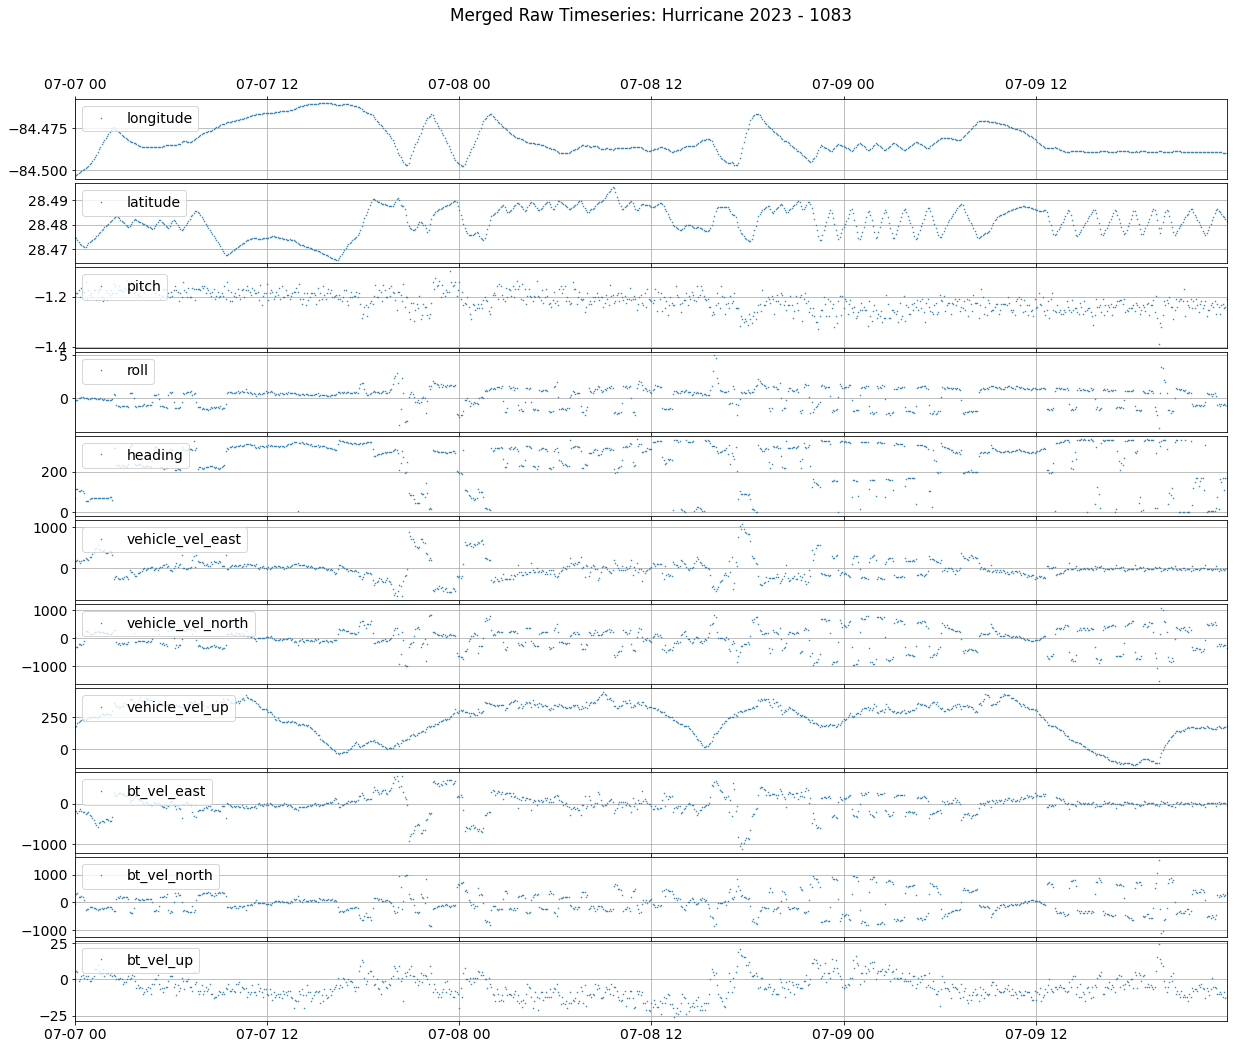

In [12]:
### plot merged raw data (1D data)
print(list(vars_dic.keys()))
vars_plot = ['longitude','latitude','pitch','roll','heading','vehicle_vel_east','vehicle_vel_north','vehicle_vel_up','bt_vel_east','bt_vel_north','bt_vel_up']
nrow = len(vars_plot)
tlim = [dtime[0],dtime[-1]]
### initiate plot
plt.clf()
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(nrow,1)
fig.set_size_inches(20,16)
for i in range( nrow ):
    vkey = vars_plot[i]
    print(vkey)
    data = vars_dic[vkey]
    h = plt.subplot(nrow,1,i+1)
    plt.plot(dtime,data,'.',ms=1)
    plt.xlim(tlim)
    plt.grid()
    plt.legend(h,labels=[vkey],loc='upper left')
    if i == 0:
        plt.gca().xaxis.set_ticks_position('top')
    elif i < nrow-1:
        plt.gca().set_xticklabels('')
    
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.05)
plt.suptitle('Merged Raw Timeseries: Hurricane '+year+' - '+platf_num)
fig.savefig(pathout+'merge_raw_1D_'+year+'-'+platf_num+'-adcp.png', dpi=300,bbox_inches='tight')

['time', 'latitude', 'longitude', 'cell_depth', 'roll', 'pitch', 'heading', 'vel_east', 'vel_north', 'vel_up', 'error_vel', 'echo_intensity', 'correlation', 'vehicle_vel_north', 'vehicle_vel_east', 'vehicle_vel_up', 'bt_range', 'bt_cor', 'bt_vel_east', 'bt_vel_north', 'bt_vel_up', 'bt_amp', 'bt_percent_good', 'percent_good_4_beam', 'percent_good_3_beam', 'percent_good']
vel_east
vel_north
vel_up
error_vel
percent_good_4_beam
percent_good_3_beam
percent_good


Text(0.5, 0.98, '/Users/chi/Documents/projects/sd-ni-wp/data_manipulate/fig_merge_raw_adcp/Merged Raw Timeseries: Hurricane 2023 - 1083')

<Figure size 432x288 with 0 Axes>

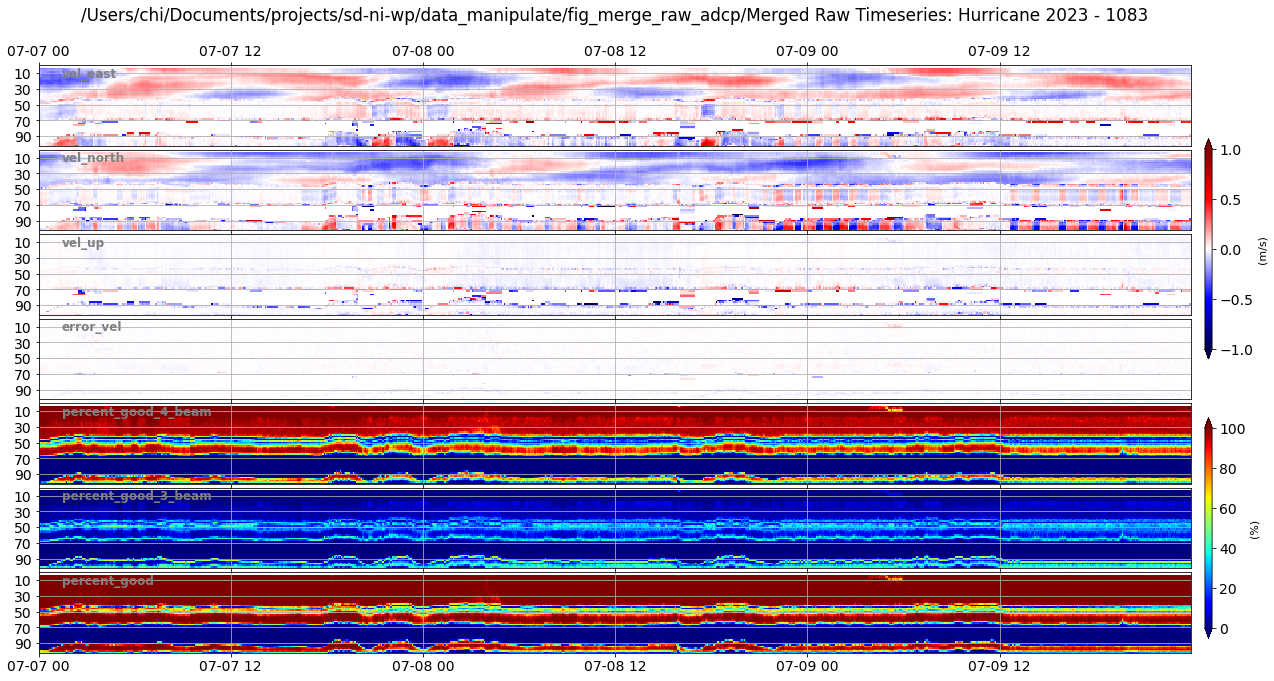

In [15]:
### plot merged raw data (2D data)
print(list(vars_dic.keys()))
vars_plot = ['vel_east','vel_north','vel_up','error_vel','percent_good_4_beam','percent_good_3_beam','percent_good']
nrow = len(vars_plot)
tlim = [dtime[0],dtime[-1]]
zlim = [0,np.max(vars_dic['cell_depth'])]
### initiate plot
plt.clf()
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(nrow,1)
fig.set_size_inches(20,10.2)
for i in range( nrow ):
    vkey = vars_plot[i]
    print(vkey)
    data = vars_dic[vkey]
    plt.subplot(nrow,1,i+1)
    if i < 4: # velocities
        # dmin = np.nanmin(data)
        # dmax = np.nanmax(data)
        dlim = [-1,1]#np.max([abs(dmin),abs(dmax)])*np.array([-1,1])
        cmap = 'seismic'
    else: # percentage
        dlim = [0,100]
        cmap = 'jet'
    cs = plt.pcolormesh(dtime,vars_dic['cell_depth'],data.transpose(),vmin=dlim[0],vmax=dlim[1],cmap=cmap)
    plt.xlim(tlim)
    plt.ylim(zlim)
    plt.gca().invert_yaxis()
    plt.yticks(np.arange(10,110,20))
    plt.grid()
    # plt.legend(cs,labels=[vkey],loc='upper left')
    plt.gca().set_title(vkey, x=0.02, y=1, pad=-12, fontsize=12, color='gray', fontweight='bold', horizontalalignment='left')
    ### figure settings
    if i == 0:
        plt.gca().xaxis.set_ticks_position('top')
    elif i < nrow-1:
        plt.gca().set_xticklabels('')

    ### add colorbar - m/s
    if i == 0:
        cbar_ax = fig.add_axes([.91,.5,.005,0.3])
        axf = plt.colorbar(cs,orientation='vertical',cax=cbar_ax,extend='both')
        axf.set_label('(m/s)',fontsize=11)
    if i == 4:
        cbar_ax = fig.add_axes([.91,.12,.005,0.3])
        axf = plt.colorbar(cs,orientation='vertical',cax=cbar_ax,extend='both')
        axf.set_label('(%)',fontsize=11)
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.05)
plt.suptitle(pathout+'Merged Raw Timeseries: Hurricane '+year+' - '+platf_num)
# fig.savefig(pathout+'merge_raw_2D_'+year+'-'+platf_num+'-adcp.png', dpi=300,bbox_inches='tight')

['time', 'latitude', 'longitude', 'cell_depth', 'roll', 'pitch', 'heading', 'vel_east', 'vel_north', 'vel_up', 'error_vel', 'echo_intensity', 'correlation', 'vehicle_vel_north', 'vehicle_vel_east', 'vehicle_vel_up', 'bt_range', 'bt_cor', 'bt_vel_east', 'bt_vel_north', 'bt_vel_up', 'bt_amp', 'bt_percent_good', 'percent_good_4_beam', 'percent_good_3_beam', 'percent_good']
echo_intensity
correlation
bt_range


Text(0.5, 0.98, 'Merged Raw Timeseries: Hurricane 2023 - 1083')

<Figure size 432x288 with 0 Axes>

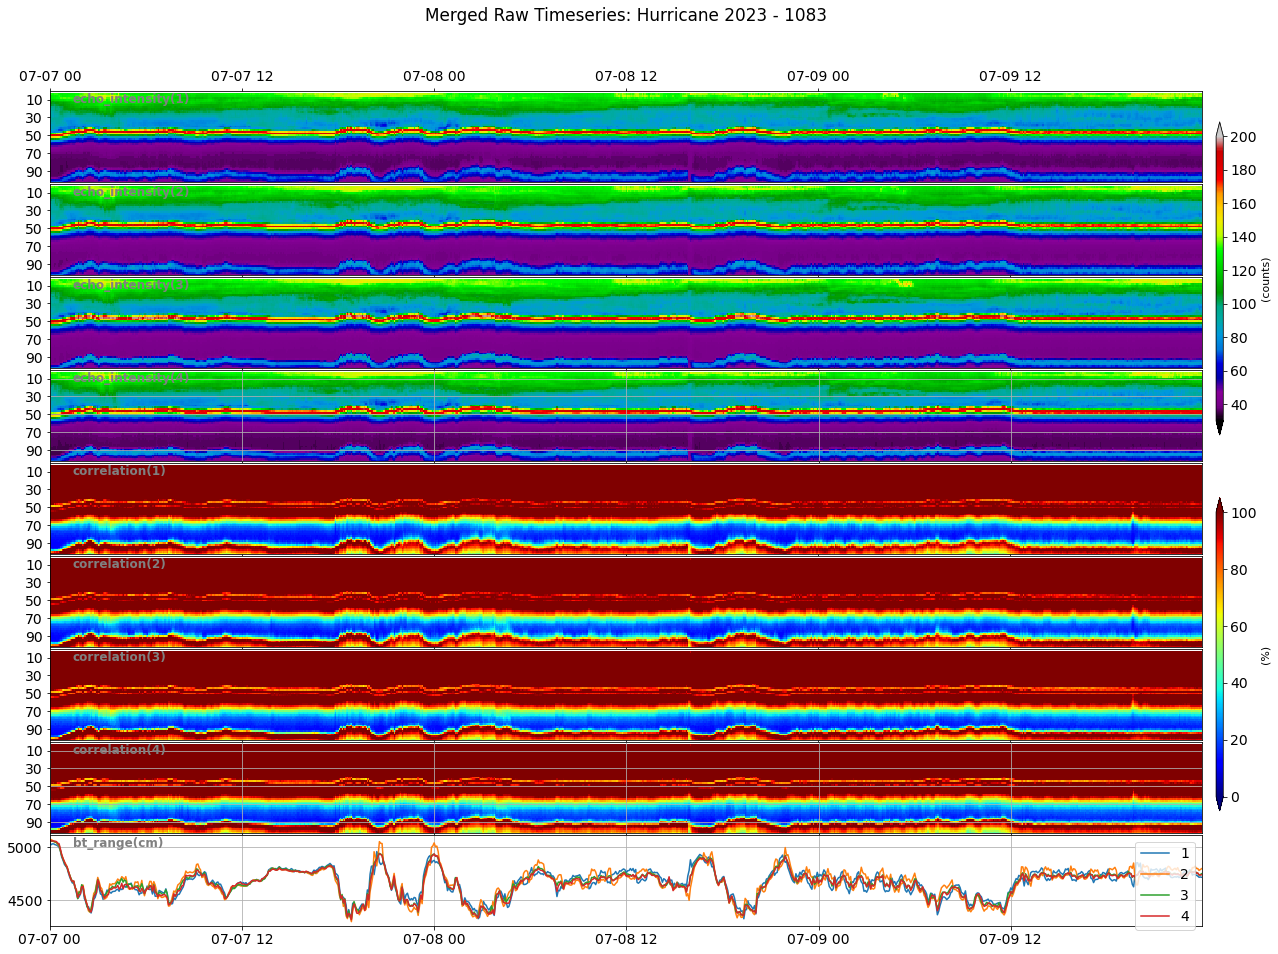

In [20]:
### plot merged raw data (3D data)
print(list(vars_dic.keys()))
vars_plot = ['echo_intensity','correlation','bt_range']
nbeam = 4
nrow = len(vars_plot)*(nbeam-1)
tlim = [dtime[0],dtime[-1]]
zlim = [0,np.max(vars_dic['cell_depth'])]
### initiate plot
plt.clf()
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(nrow,1)
fig.set_size_inches(20,14.5)
for i in range( len(vars_plot) ):
    vkey = vars_plot[i]
    print(vkey)
    data = vars_dic[vkey]
    cmap = 'jet'
    if i == 0: # echo intensity
        # dmin = np.nanmin(data)
        # dmax = np.nanmax(data)
        # dlim = [dmin,dmax]
        dlim = [30,200]
        cmap = 'nipy_spectral'
    elif i == 1: # correlation
        dlim = [0,100]
        cmap = 'jet'
    elif i == 2: # bt_range
        dmin = np.nanmin(data)
        dmax = np.nanmax(data)
        dlim = [dmin,dmax]
    ### plot 4 beams
    for b in range(nbeam):
        if i == 2: ### bt_range is 1D: plot in one plot
            plt.subplot(nrow,1,i*4+1)
            data_plot = data[:,b]
            h = plt.plot(dtime,data_plot,label=str(b+1))
            plt.legend()
            plt.gca().set_title(vkey+'(cm)', x=0.02, y=1, pad=-12, fontsize=12, \
                                color='gray', fontweight='bold', horizontalalignment='left')
        else:
            plt.subplot(nrow,1,i*4+b+1)
            data_plot = data[:,b,:].transpose()
            cs = plt.pcolormesh(dtime,vars_dic['cell_depth'],data_plot,vmin=dlim[0],vmax=dlim[1],cmap=cmap)
            plt.ylim(zlim)
            plt.gca().invert_yaxis()
            plt.yticks(np.arange(10,110,20))
            plt.gca().set_title(vkey+'('+str(b+1)+')', x=0.02, y=1, pad=-12, fontsize=12, \
                                color='gray', fontweight='bold', horizontalalignment='left')
            if (i == 0) & (b == 0):
                plt.gca().xaxis.set_ticks_position('top')
            else:
                plt.gca().set_xticklabels('')
    ### axes settings    
    plt.xlim(tlim)
    plt.grid()
    
    ### add colorbar - m/s
    if i == 0: # echo intensity (counts)
        cbar_ax = fig.add_axes([.91,.57,.005,0.3])
        axf = plt.colorbar(cs,orientation='vertical',cax=cbar_ax,extend='both')
        axf.set_label('(counts)',fontsize=11)
    elif i == 1:
        cbar_ax = fig.add_axes([.91,.21,.005,0.3])
        axf = plt.colorbar(cs,orientation='vertical',cax=cbar_ax,extend='both')
        axf.set_label('(%)',fontsize=11)
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.02)
plt.suptitle('Merged Raw Timeseries: Hurricane '+year+' - '+platf_num)
# fig.savefig(pathout+'merge_raw_4beams_'+year+'-'+platf_num+'-adcp.png', dpi=300,bbox_inches='tight')